In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

device = torch.device('cuda:0')

In [2]:
class PUBG_imglike_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        def transfrom2imglike(input):
            output = np.zeros((3,32,32))
            temp = np.array(input)
            for x in range(23):
                for y in range(23):
                    if(x == y):
                        output[0][x][y] = temp[x]
                        output[1][x][y] = temp[x]
                        output[2][x][y] = temp[x]
            return output
        # get one line in csv
        player_id = self.frame.iloc [idx, 0]
        player_stats = self.frame.iloc [idx, [x for x in range(3, 27) if x != 15]].values.astype(np.int_)
        player_stats = torch.tensor(transfrom2imglike(player_stats))
        win_place_perc = torch.tensor(self.frame.iloc [idx, 28])
        if self.transform:
            player_stats = self.transform(player_stats)
        sample = {
            "player_id": player_id, 
            "player_stats": player_stats,
            "win_place_perc": win_place_perc
        }
        return sample

In [3]:
def get_dataset(csv_file, train_dataset_size_ratio, batch_size):
    dataset = PUBG_imglike_dataset(csv_file)
    #  `torch.utils.data.random_split` meets server problem and lead to CRASH
    # see also:
    # - a denied fix PR for this problem: https://github.com/pytorch/pytorch/pull/9237 
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor((1-train_dataset_size_ratio) * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print("load dataset: train dataset: {}, test dataset: {}.".format(len(train_loader)*batch_size, len(test_loader)*batch_size))
    return (train_loader, test_loader)

In [4]:
# load dataset
csv_file = 'train_small.csv'
train_dataset_size_ratio = 0.9
batch_size = 128
train_loader, test_loader = get_dataset(csv_file, train_dataset_size_ratio, batch_size)

load dataset: train dataset: 1152, test dataset: 128.


In [5]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [6]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    # train the model using minibatch
    for i, data in enumerate(train_loader):
        stats, prec = data['player_stats'], data['win_place_perc']
        stats, prec = stats.to(torch.float32).to(device), prec.to(device)

        # forward
        outputs = model(stats)
        loss = loss_func(outputs, prec)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        #if (i + 1) % 10 == 0:
        #    print ("Step [{}/{}] Train Loss: {:.4f}".format(i+1, len(train_loader), loss.item()))
    #print ("Train Loss: {:.4f}".format(loss.item()))
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):

    model.eval()
    with torch.no_grad():
        loss = 0
        total = 0
        
        for i, data in enumerate(val_loader):
            stats, prec = data['player_stats'], data['win_place_perc']
            stats, prec = stats.to(torch.float32).to(device), prec.to(device)

            outputs = model(stats)

            
            loss += (torch.abs(torch.t(outputs) - prec)).sum()
            total += prec.size(0)

            
        accuracy = loss / total
        #print('Test Loss: {:.4f}'.format(accuracy))
        return accuracy
    
def fit(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")

In [7]:

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        """
        Defines the computation performed at every call.
        x: N * C * H * W
        """
        residual = x
        # if the size of input x changes, using downsample to change the size of residual
        if self.downsample:
            residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        
        """
        To-Do: add code here        
        """
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        """
        block: ResidualBlock or other block
        layers: a list with 3 positive num.
        """
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # layer1: image size 32
        self.layer1 = self.make_layer(block, 16, num_blocks=layers[0])
        # layer2: image size 32 -> 16
        self.layer2 = self.make_layer(block, 32, num_blocks=layers[1], stride=2)
        # layer1: image size 16 -> 8
        self.layer3 = self.make_layer(block, 64, num_blocks=layers[2], stride=2)
        # global avg pool: image size 8 -> 1
        self.avg_pool = nn.AvgPool2d(8)
    
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        """
        make a layer with num_blocks blocks.
        """
        
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            # use Conv2d with stride to downsample
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # first block with downsample
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        # add num_blocks - 1 blocks
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        # return a layer containing layers
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        # view: here change output size from 4 dimensions to 2 dimensions
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
resnet = ResNet(ResidualBlock, [2, 2, 2], 1)
print(resnet)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [13]:
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32
num_classes = 1

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:0')

optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

Epoch 10/100
Train Loss: 0.0888
Test Loss: 0.2803
Epoch 20/100
Train Loss: 0.0926
Test Loss: 0.2779
Epoch 30/100
Train Loss: 0.0903
Test Loss: 0.2792
Epoch 40/100
Train Loss: 0.0916
Test Loss: 0.2784
Epoch 50/100
Train Loss: 0.0969
Test Loss: 0.2775
Epoch 60/100
Train Loss: 0.0948
Test Loss: 0.2820
Epoch 70/100
Train Loss: 0.0919
Test Loss: 0.2790
Epoch 80/100
Train Loss: 0.0953
Test Loss: 0.2781
Epoch 90/100
Train Loss: 0.0934
Test Loss: 0.2789
Epoch 100/100
Train Loss: 0.0906
Test Loss: 0.2778


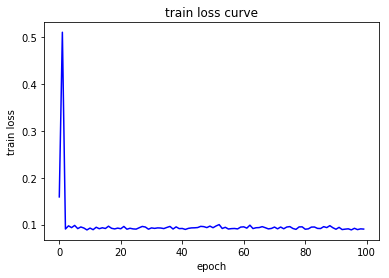

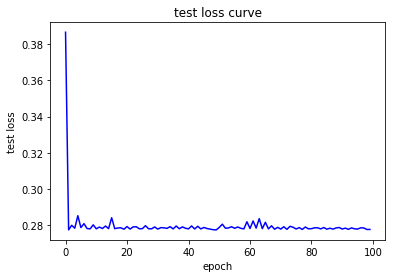

In [14]:
fit(resnet, num_epochs, optimizer, device)